## Correcting ICESat-2 data and related applications

Maya Becker (m3becker@ucsd.edu) and Susheel Adusumilli (suadusum@ucsd.edu), Scripps Institution of Oceanography, UC San Diego

(Thank you to Matt Siegfried and Cyrille Mosbeux for their comments!)

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from is2_utils import *
import geopandas as gpd
from matplotlib import path, patches
from glob import glob
import h5py
from scipy.io import loadmat
from scipy import interpolate

### Part 1: Application of geophysical corrections over ice shelves

In the first part of this tutorial, we will discuss which geophysical corrections we should apply in which scenarios. We will use floating ice shelves as our application example since the height of these surfaces responds to atmospheric and ocean dynamics, requiring several corrections to estimate the "neutral" height. While we will focus on ice shelves, many of the corrections that we apply to altimetry data over ice shelves are also required for science applications of altimetry data over icebergs, sea ice, oceans, and lakes, so we hope that this tutorial can prove useful for both ice-shelf scientists and those who focus on other elements of the cryosphere.

You can find an overview of the corrections applied to the ICESat-2 ATL03 data product in Markus et al. (2017). We will not discuss the solid earth tides correction, solid earth and ocean pole tide corrections, and atmospheric range delay correction.

<img src="figures/Markus_et_al_2017_Table_2.png" width="1000" height="1000"/>

We will start with the same ATL06 data that Ben used in his cloud and data quality tutorial (i.e., the HDF5 data over Byrd Glacier). If you have not downloaded this data, please head over to his <a href="https://github.com/ICESAT-2HackWeek/Clouds_and_data_filtering" target="_blank">cloud and data filtering notebook</a> and follow his download instructions just before his Section 0. Alternatively, use an uncommmented version of the cell below to download the data from S3.

In [2]:
# %%bash
# aws s3 cp s3://pangeo-data-upload-oregon/icesat2/Clouds_and_filtering_tutorial/ATL06 /home/jovyan/ATL06 --recursive

We will use a modified version of the code that he ran to extract the fields relevant to this tutorial from each HDF5 file: latitude, longitude, land-ice height, ocean tide correction, ocean tidal loading correction, dynamic atmosphere correction (with inverted barometer effect), and geoid height. Note that this code also includes a conversion of the latitude–longitude pairs to polar stereographic x-y grid coordinates, done with a function stored in is2_utils.py.

In [2]:
atl06_data = '/home/jovyan/ATL06'
external_data = '/home/jovyan/external_data'
data_dir = atl06_data + '/Byrd_Glacier_rel001'
D6 = []
datasets = {'land_ice_segments': ['h_li','latitude','longitude','atl06_quality_summary'],
             'land_ice_segments/geophysical': ['tide_load','dac','tide_ocean'],
             'land_ice_segments/dem': ['geoid_h']}
files = glob(data_dir + '/*.h5')

pairs=[1, 2, 3]
beams=['r']  # Note, we are only loading one beam from each pair for faster run-time
for file in files[::2]:
    this_name = os.path.basename(file)
    with h5py.File(file) as h5f:
        for pair in pairs:
            for beam in beams:
                temp = {}
                for group in datasets.keys():
                    for dataset in datasets[group]:
                        DS = '/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        try:
                            temp[dataset] = np.array(h5f[DS])                            
                            if '_FillValue' in h5f[DS].attrs: # Converting Fortran NaNs to Python NaNs
                                fill_value = h5f[DS].attrs['_FillValue']
                                temp[dataset][temp[dataset] == fill_value] = np.NaN
                        except KeyError:
                            pass
                if len(temp) > 0:
                    temp['x'],temp['y'] = ll2ps(temp['longitude'],temp['latitude'], \
                                                    slat=71, slon=0, hemi='s', units='m')
                    temp['mask'] = np.empty_like(temp['y'])
                    temp['FAC_interp'] = np.empty_like(temp['y'])
                    temp['h_li'][temp['atl06_quality_summary']] = np.NaN
                    D6.append(temp)
                    
print("read %d beams" % (len(D6)))

read 133 beams


Now let's see what the data look like. We're going to plot this over the MODIS Mosaic of Antarctica (MOA). We have put a small subset of MOA on AWS, which we need to download. Then we will plot raw 
ATL06 elevations and speed this process up a bit by only using every 20th data point.

In [3]:
%%bash
aws s3 cp s3://pangeo-data-upload-oregon/icesat2/data-correction/byrd_moa.mat /home/jovyan/external_data/ 

download: s3://pangeo-data-upload-oregon/icesat2/data-correction/byrd_moa.mat to ../../external_data/byrd_moa.mat


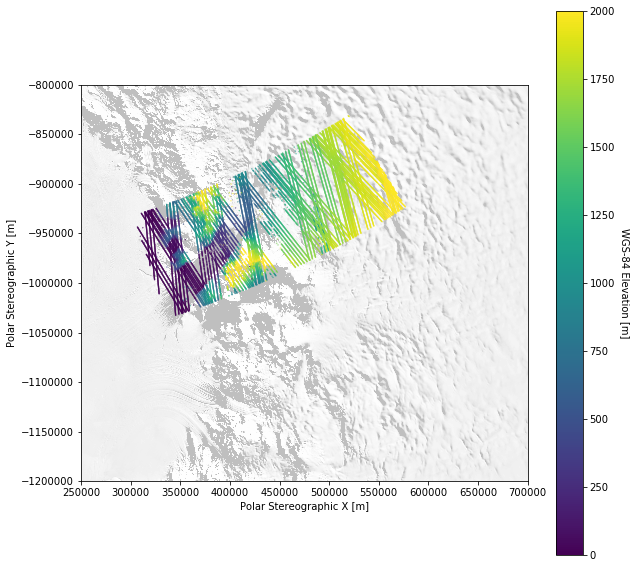

In [4]:
plt.figure(figsize = (10,10))

def plot_moa():
    moa = loadmat(external_data + '/byrd_moa.mat')
    extent = [np.min(moa['x']),np.max(moa['x']),np.min(moa['y']),np.max(moa['y'])]
    plt.imshow(np.squeeze(moa['moa']),extent=extent)

plot_moa()
for Di in D6:
    plt.scatter(Di['x'][::20],Di['y'][::20],c = Di['h_li'][::20],s = 0.1,vmin = 0,vmax = 2000)
cbar = plt.colorbar()
cbar.set_label("WGS-84 Elevation [m]", rotation = 270, labelpad = 15)

plt.xlim([250000,700000])
plt.ylim([-1200000,-800000])
plt.xlabel('Polar Stereographic X [m]')
plt.ylabel('Polar Stereographic Y [m]');

#### Masking the grounded ice

First things first, we need to mask out the grounded ice so that we only apply the floating-ice corrections to the ATL06 data on the area of Ross Ice Shelf fed by Byrd Glacier.

The floating-/grounded-ice mask used by NASA to apply the tide models to ICESat-2 data is at quite a low resolution, so it is preferable to mask the data seperately. We will use ice-shelf polygons (available at https://nsidc.org/data/nsidc-0709) to subset the data over floating ice. First, we need to download the data from our web server, then load the shapefile 'IceShelf_Antarctica_v1.shp' and plot all the ice shelf polygons. (Note that you also need to have the corresponding CPG, DBF, PRJ, and SHX files accessible in order for the shapefile to be loaded successfully.)

In [5]:
%%bash
aws s3 cp s3://pangeo-data-upload-oregon/icesat2/data-correction/ /home/jovyan/external_data/ --recursive --exclude "*" --include "IceShelf_Antarctica_v1.*"

download: s3://pangeo-data-upload-oregon/icesat2/data-correction/IceShelf_Antarctica_v1.shx to ../../external_data/IceShelf_Antarctica_v1.shx
download: s3://pangeo-data-upload-oregon/icesat2/data-correction/IceShelf_Antarctica_v1.dbf to ../../external_data/IceShelf_Antarctica_v1.dbf
download: s3://pangeo-data-upload-oregon/icesat2/data-correction/IceShelf_Antarctica_v1.prj to ../../external_data/IceShelf_Antarctica_v1.prj
download: s3://pangeo-data-upload-oregon/icesat2/data-correction/IceShelf_Antarctica_v1.cpg to ../../external_data/IceShelf_Antarctica_v1.cpg
download: s3://pangeo-data-upload-oregon/icesat2/data-correction/IceShelf_Antarctica_v1.shp to ../../external_data/IceShelf_Antarctica_v1.shp


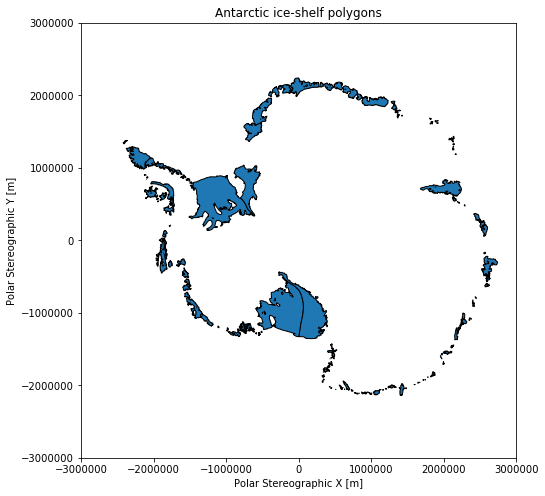

In [6]:
from descartes.patch import PolygonPatch

plt.figure(figsize = (8,8))
ax = plt.axes()
ax.set_aspect('equal')

shapefile = gpd.read_file(external_data + '/IceShelf_Antarctica_v1.shp')
for polygon in shapefile.geometry:
    patch = PolygonPatch(polygon)
    ax.add_patch(patch)
plt.xlim([-3000e3,3000e3])
plt.ylim([-3000e3,3000e3])
plt.title('Antarctic ice-shelf polygons')
plt.xlabel('Polar Stereographic X [m]')
plt.ylabel('Polar Stereographic Y [m]');

Because we are only interested in Byrd Glacier, we use the polygon for the East Antarctic Ice Sheet (EAIS) section of Ross Ice Shelf to identify the area of floating ice. We also append the coordinate pairs corresponding to the floating area to the list 'D6.' Again, to speed the process up, we only plot every 20th point. 

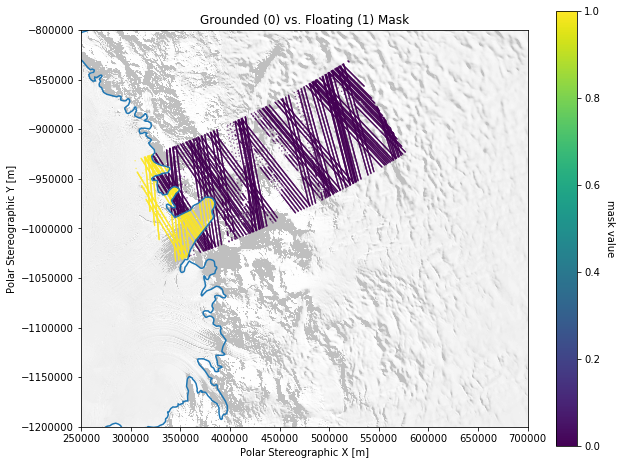

In [7]:
polygon = shapefile.geometry[76] # Item 76 is the polygon for the EAIS section of Ross Ice Shelf
xp, yp = polygon.exterior.coords.xy
coords = np.squeeze(np.dstack((xp,yp)))
poly_mpl = path.Path(coords)

for Di in D6: # Add 'mask' dataset (containing the x-y coordinate pairs within the mask) to list D6 for each beam/pair combination
    Di['mask'] = poly_mpl.contains_points(np.transpose([Di['x'],Di['y']]))

plt.figure(figsize = (10,8))

plot_moa()
plt.plot(*polygon.exterior.xy);

for Di in D6:
    plt.scatter(Di['x'][::20],Di['y'][::20],c = Di['mask'][::20],s = 0.1)
    plt.clim([0,1])
plt.xlabel('Polar Stereographic X [m]')
plt.ylabel('Polar Stereographic Y [m]')
plt.xlim([250000,700000])
plt.ylim([-1200000,-800000])
plt.title("Grounded (0) vs. Floating (1) Mask");

cbar = plt.colorbar();
cbar.set_label("mask value", rotation = 270, labelpad = 15)

#### Ocean tides and ocean tidal loading

Let us first take a quick look at the spatial variability of the GOT 4.8 model output for the ocean tides and ocean tidal loading in the floating section of the Byrd Glacier data. These are the models NASA provides as part of the official ICESat-2 data products. This should take a moment to run.

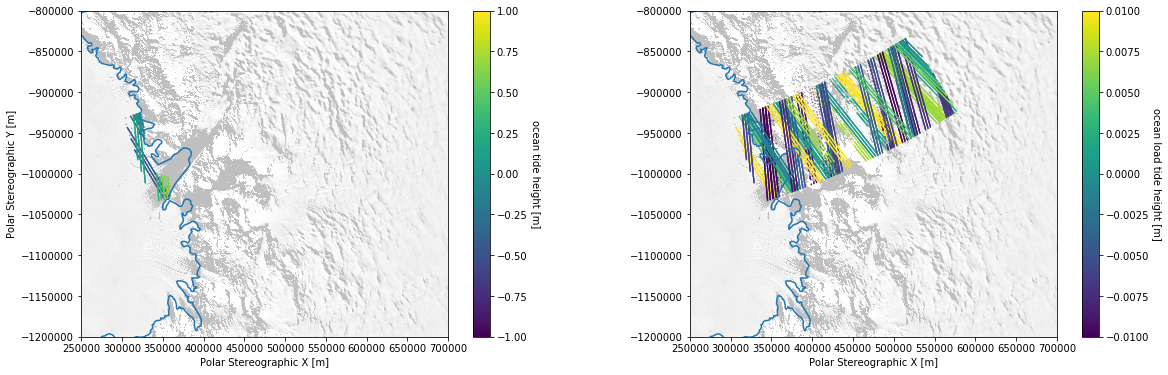

In [8]:
plt.figure(figsize = (20,6))

plt.subplot(121)
plot_moa()
for Di in D6:
    plt.scatter(Di['x'][::20],Di['y'][::20],c = Di['tide_ocean'][::20],s = 0.1,vmin=-1,vmax=1)

cbar = plt.colorbar()
cbar.set_label('ocean tide height [m]', rotation=270, labelpad = 12)

plt.plot(*polygon.exterior.xy)
plt.xlim([250000,700000])
plt.ylim([-1200000,-800000])
plt.xlabel('Polar Stereographic X [m]')
plt.ylabel('Polar Stereographic Y [m]')

plt.subplot(122)
plot_moa()
for Di in D6:
    plt.scatter(Di['x'][::20],Di['y'][::20],c = Di['tide_load'][::20],s = 0.1,vmin=-0.01,vmax=0.01)

cbar = plt.colorbar()
cbar.set_label('ocean load tide height [m]', rotation=270, labelpad = 12)

plt.plot(*polygon.exterior.xy)
plt.xlim([250000,700000])
plt.ylim([-1200000,-800000])
plt.xlabel('Polar Stereographic X [m]');

Note the difference in scale between both corrections! The ATL06 data are already corrected for ocean tidal loading, so we would only need to account for the ocean tides before we move on to the dynamic atmosphere correction. Because we only have GOT 4.8 tidal heights for a small portion of our data set, we will not remove them in this demo.

For reference, here is what the Circum-Antarctic Tidal Simulation (CATS) 2008 model (modified from Padman et al., 2002) output looks like in this area:

<img src="https://igppweb.ucsd.edu/~suadusumilli/ris_tide_height_padman.png" width="400" height="400"/>

CATS2008 has a higher spatial resolution than GOT 4.8 and is optimized for Antarctic applications, so tidal correction values extend further into the inlet. Similar regional tide models will be more appropriate than the default model in other regions. The main takeaway here is to look at the default values because they might not be perfect for a specific application.

TO ADD: discussion of different tide models for different regions

#### Dynamic atmosphere correction and inverted barometer effect

TO ADD: overview of DAC and Mog2D product
DAC/IBE are not applicable over land, however, so we need to mask them out.

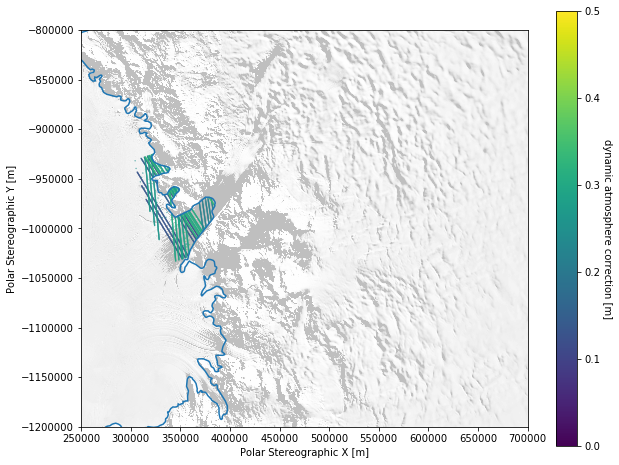

In [10]:
plt.figure(figsize = (10,8))
plot_moa()
for Di in D6:
    plt.scatter(Di['x'][Di['mask']][::20],Di['y'][Di['mask']][::20],c = Di['dac'][Di['mask']][::20],s = 0.1,vmin=0,vmax=0.5)
cbar = plt.colorbar()
cbar.set_label('dynamic atmosphere correction [m]', rotation=270, labelpad = 12)

plt.plot(*polygon.exterior.xy);
plt.xlim([250000,700000])
plt.ylim([-1200000,-800000]);

plt.xlabel('Polar Stereographic X [m]')
plt.ylabel('Polar Stereographic Y [m]');

#### Mean dynamic topography and conversion to geoid model to generate heights above mean sea surface

(Include overview of MDT correction and Mog2D product)

(Include overview of referencing heights to a geoid and different geoid models available)

Estimates of MDT are continually improving, and at the moment, it is fairly standard to just apply a single correction for an entire ice-shelf region. We hope that ICESat-2 and ocean modeling can help us to extend MDT estimates to ice-shelf cavities!

### Part 2: Derivation of ice-shelf height changes and conversion to mass changes

In [5]:
from netCDF4 import Dataset, num2date

#### Correction for the presence of a firn layer

We will now use a quantity called firn air content (FAC; see Ligtenberg et al. [2011]) from RACMO to correct for the presence of a firn layer of a certain mass and volume. In essence, FAC describes the "length" of the firn air column, which is estimated as the thickness change that would result from the compression of the firn column to the density of ice. As always, step 1 is downloading the data, then we will manipulate it.

Here's a typical set of firn density profiles around Antarctica (from Ligtenberg et al., 2011). The density at the surface is around 400–500 kg/m^3 and increases with depth and eventually reaches the density of continental ice, typically 917 kg/m^3.

<img src="figures/firn_density.png" width="400" height="400"/>

In [10]:
%%bash
aws s3 cp s3://pangeo-data-upload-oregon/icesat2/data-correction/ /home/jovyan/external_data/ --recursive --exclude "*" --include "FDM_*.nc"

download: s3://pangeo-data-upload-oregon/icesat2/data-correction/FDM_FirnAir_ANT27_1979-2016.nc to ../../external_data/FDM_FirnAir_ANT27_1979-2016.nc


In [6]:
FAC = Dataset(external_data + '/FDM_FirnAir_ANT27_1979-2016.nc')

print(FAC.file_format)
print(FAC.dimensions.keys()) # in this case, dimensions represent the physical dimensions assigned to each variable
print(FAC.variables.keys()) # variables are arrays of values where the bulk of the information is stored

NETCDF3_CLASSIC
odict_keys(['time', 'rlat', 'rlon'])
odict_keys(['FirnAir', 'lsm', 'lat', 'lon', 'time'])


In [7]:
lat_fac = FAC.variables['lat'][:]
lon_fac = FAC.variables['lon'][:]
FirnAir = FAC.variables['FirnAir'][:]
time_fac = FAC.variables['time'][:]

Let us take a quick look at how FAC varied across the Ross Ice Shelf region in the year 2016. This is the last year for which RACMO outputs are currently available. Future RACMO runs and current atmospheric and firn modeling efforts at NASA Goddard Space Flight Center (Brooke Medley, personal communication) will extend this time series to the present.

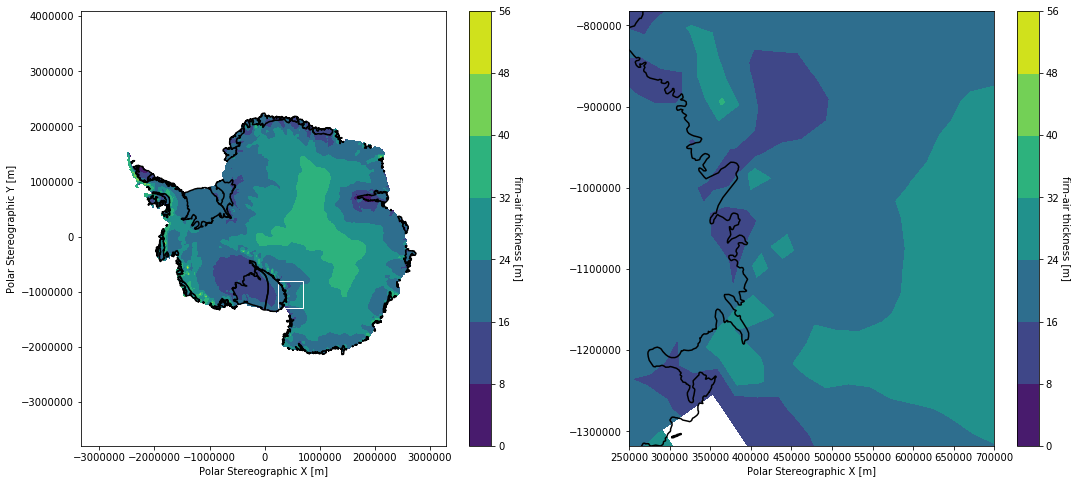

In [13]:
time_16_inds = np.where((time_fac > 2015.99) & (time_fac < 2017))
time_16 = time_fac[time_16_inds]
FirnAir_16 = FirnAir[time_16_inds,:,:]
meanFirnAir_16 = np.squeeze(np.mean(FirnAir_16,1))

plt.figure(figsize = (18,8))
[x_fac,y_fac] = ll2ps(lon_fac,lat_fac,slat = 71, slon = 0, hemi = 's', units = 'm')
ax = plt.subplot(121)
plt.contourf(x_fac,y_fac,meanFirnAir_16)
plt.axis('equal')
plt.xlabel('Polar Stereographic X [m]')
plt.ylabel('Polar Stereographic Y [m]');

cbar = plt.colorbar()
cbar.set_label('firn-air thickness [m]', rotation = 270, labelpad = 12)

for polygon in shapefile.geometry:
    plt.plot(*polygon.exterior.xy,color = 'black');
p = patches.Rectangle((250000, -1300000),450000,500000,fill=False,color='white')
ax.add_patch(p)

plt.subplot(122)
plt.contourf(x_fac,y_fac,meanFirnAir_16)
plt.axis('equal')

cbar = plt.colorbar()
cbar.set_label('firn-air thickness [m]', rotation = 270, labelpad = 12)

for polygon in shapefile.geometry:
    plt.plot(*polygon.exterior.xy,color = 'black');
plt.xlim([250000,700000])
plt.ylim([-1300000,-800000]);
plt.xlabel('Polar Stereographic X [m]');

Byrd glacier is a special case because it’s primarily a blue ice region because of large katabatic winds blowing most of the snowfall away, and therefore the firn air content there is nearly zero.

#### Conversion from height above mean sea surface (h_MSS) to thickness with RACMO h_FAC

In [14]:
inds = np.where((lon_fac > 147) & (lon_fac < 163) & (lat_fac > -82) & (lat_fac < -78)) # Subsetting area around Byrd
mean_fac_byrd = np.squeeze(meanFirnAir_16[inds]).ravel()
xy = np.empty((len(x_fac[inds]),2))
xy[:,0] = np.squeeze(x_fac[inds]).ravel()
xy[:,1] = np.squeeze(y_fac[inds]).ravel()

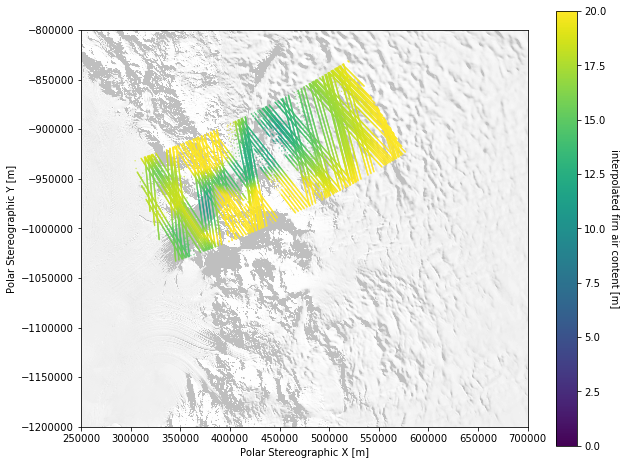

In [15]:
plt.figure(figsize = (10,8))
plot_moa()

for Di in D6:
    xy_data = np.empty((len(Di['x']),2))
    xy_data[:,0] = np.squeeze(Di['x']).ravel()
    xy_data[:,1] = np.squeeze(Di['y']).ravel()
    Di['FAC_interp'] = interpolate.griddata(xy,mean_fac_byrd,xy_data)
    plt.scatter(Di['x'][::20],Di['y'][::20],c = Di['FAC_interp'][::20],s = 0.1)#,vmin=0,vmax=5)
    plt.clim([0,20])
cbar = plt.colorbar()
cbar.set_label('interpolated firn air content [m]', rotation=270, labelpad = 12)

plt.plot(*polygon.exterior.xy);
plt.xlim([250000,700000])
plt.ylim([-1200000,-800000]);

plt.xlabel('Polar Stereographic X [m]')
plt.ylabel('Polar Stereographic Y [m]');

To convert from ice shelf height to thickness, we first need to subtract the geophysical corrections obtain the height above the mean sea surface (h_msl). We can then convert h_mss to ice shelf thickness by accounting for firn air content (H_a) buoyancy using the following equation (Moholdt et al., 2014):

<img src="figures/Moholdt_et_al_2014_Equation_S1.png" width="200" height="400"/>

In [16]:
MDT_corr = -1.4;
rho_ice = 917.; rho_ocean = 1028.

%matplotlib widget

plt.figure(figsize = (8,6))
plot_moa()

for Di in D6:
    h_MSL = Di['h_li'] - MDT_corr - Di['geoid_h']
    thickness = ((1/rho_ice - 1/rho_ocean)**(-1)) * ((h_MSL - Di['FAC_interp'])/rho_ice)
    plt.scatter(Di['x'][Di['mask']][::20],Di['y'][Di['mask']][::20],c = thickness[Di['mask']][::20],s = 0.1)
    plt.clim([0,1000])
cbar = plt.colorbar()
cbar.set_label('thickness [m]', rotation=270, labelpad = 12)

plt.plot(*polygon.exterior.xy);
plt.xlim([250000,700000])
plt.ylim([-1200000,-800000]);

plt.xlabel('Polar Stereographic X [m]')
plt.ylabel('Polar Stereographic Y [m]');

FigureCanvasNbAgg()

In [ ]:
plt.figure(figsize = (10,8))
plot_moa()
for Di in D6:
    plt.scatter(Di['x'][Di['mask']][::20],Di['y'][Di['mask']][::20],c = Di['dac'][Di['mask']][::20],s = 0.1,vmin=0,vmax=0.5)
cbar = plt.colorbar()
cbar.set_label('dynamic atmosphere correction [m]', rotation=270, labelpad = 12)

plt.plot(*polygon.exterior.xy);
plt.xlim([250000,700000])
plt.ylim([-1200000,-800000]);

plt.xlabel('Polar Stereographic X [m]')
plt.ylabel('Polar Stereographic Y [m]');

FigureCanvasNbAgg()

#### Conversion from height changes to mass changes 

Over grounded ice, several atmospheric and glaciological processes can cause height changes. To correct for some of these changes, we can use atmospheric and firn models such as RACMO (Van Wessem et al., 2017) and IMAU-FDM (Ligtenberg et al., 2011). Typically, these models incorporate two components:

<img src="figures/ligtenberg_overview.png" width="400" height="400"/>

Low-density snow added from precipitation cause increases in height while processes such as snowmelt cause compaction and decreases in height. Changes in snowfall can be obtained from models such as RACMO, ERA-Interim, and MERRA, but modeling the changes in firn density (or firn air content) requires a firn densification model.

For our region around Byrd, let’s compare the changes in firn air content with height changes from surface mass balance. Let’s assume a surface density of 450 kg/m^3 for the firn column. First, let's download the RACMO surface mass balance and load it.

In [ ]:
%%bash
aws s3 cp s3://pangeo-data-upload-oregon/icesat2/data-correction/ /home/jovyan/external_data/ --recursive --exclude "*" --include "SMB_*.nc"

In [12]:
from datetime import date, timedelta
rho_snow = 450.; 
SMB_data = Dataset(external_data + '/SMB_RACMO2.4_monthly_ANT27_197901_201612.nc')
lat_smb = SMB_data.variables['lat'][:]
lon_smb = SMB_data.variables['lon'][:]
#SMB data are in millimeters of water equivalent per month, convert to meters of ice (density 917 kg/m^3) equivalent per year
SMB = SMB_data.variables['smb'][:]*12/917
time_smb = SMB_data.variables['time']
time_smb = date2fracyr(num2date(time_smb[:], time_smb.units, time_smb.calendar))

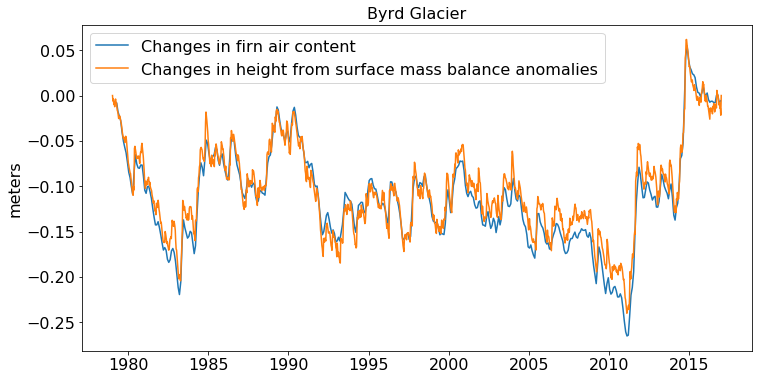

In [31]:
inds = np.where((lon_fac > 148) & (lon_fac < 162) & (lat_fac > -81) & (lat_fac < -79))
mean_fac = np.empty_like(time_fac)
for i in range(0,len(time_fac)):
    mean_fac_ = np.squeeze(FirnAir[i,:,:])
    mean_fac[i] = np.mean(mean_fac_[inds])
    
from scipy.integrate import cumtrapz
smb_to_surface_height = (rho_ice/rho_snow) - (rho_ocean-rho_ice)/rho_ice
inds = np.where((lon_smb > 148) & (lon_smb < 162) & (lat_smb > -81) & (lat_smb < -79))
mean_smb = np.empty_like(time_smb)
for i in range(0,len(time_smb)):
    mean_smb_ = np.squeeze(SMB[i,:,:])
    mean_smb[i] = smb_to_surface_height*np.mean(mean_smb_[inds])
mean_smb = mean_smb - np.mean(mean_smb) #remove mean to convert to anomalies
mean_smb = cumtrapz(mean_smb,x=time_smb) 

plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (12,6))
plt.plot(time_smb[1:],mean_smb,label='Changes in firn air content') 
plt.plot(time_fac,mean_fac - mean_fac[0],label='Changes in height from surface mass balance anomalies')
plt.legend(fontsize = 16)
plt.ylabel('meters')
plt.title('Byrd Glacier', fontsize = 16);

They look really similar! Then we might not need a firn densification model after all? Unfortunately, the answer is no.

Here’s a region where accurate treatment of firn densification does matter - we are now over Larsen C ice shelf in the Antarctic Peninsula. Over this ice shelf, changes in surface height from surface mass balance and corresponding changes in firn air content differ by a lot more.

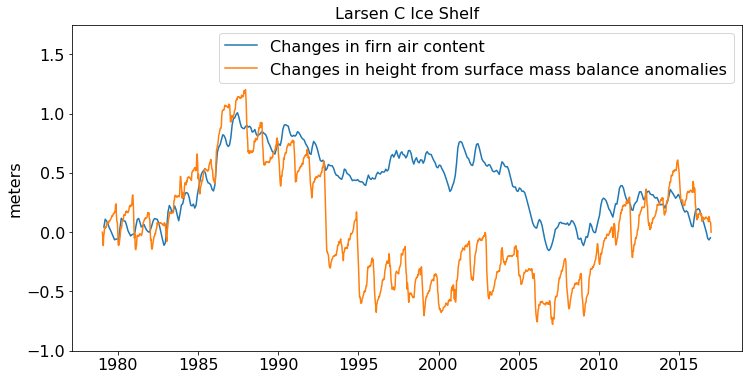

In [34]:
inds = np.where((lon_fac > -64) & (lon_fac < -62) & (lat_fac > -68) & (lat_fac < -66))
mean_fac = np.empty_like(time_fac)
for i in range(0,len(time_fac)):
    mean_fac_ = np.squeeze(FirnAir[i,:,:])
    mean_fac[i] = np.nanmean(mean_fac_[inds])
    
inds = np.where((lon_smb > -64) & (lon_smb < -62) & (lat_smb > -68) & (lat_smb < -66))
mean_smb = np.empty_like(time_smb)
for i in range(0,len(time_smb)):
    mean_smb_ = np.squeeze(SMB[i,:,:])
    mean_smb[i] = smb_to_surface_height*np.mean(mean_smb_[inds])
mean_smb = mean_smb - np.nanmean(mean_smb) #remove mean to convert to anomalies
mean_smb = cumtrapz(mean_smb,x=time_smb) 

plt.figure(figsize = (12,6))
plt.plot(time_smb[1:],mean_smb,label='Changes in firn air content') 
plt.plot(time_fac,mean_fac - mean_fac[0],label='Changes in height from surface mass balance anomalies')
plt.legend(fontsize = 16)
plt.ylim([-1,1.75])
plt.ylabel('meters')
plt.title('Larsen C Ice Shelf', fontsize = 16);

### Summary

In this tutorial, we have outlined (and provided some sample code for) the steps necessary to convert ATL06 segment elevations for a small area of Ross Ice Shelf to heights above the mean sea surface and ice-shelf thickness. Conversion from ice sheet and glacier volume change to mass change requires a high-resolution validated firn densification model. These models can have higher uncertainties than the altimetry-derived volume changes. 

Note that when using data from other satellite missions (e.g., ICESat), there will likely be different corrections, and this can affect height-change estimates. All in all, what we want you to remember from this tutorial is how important it is to look at the preloaded correction values in your area of interest and decide whether it might make sense to utilize a different geophysical model. 


### References

Ligtenberg, S. R. M., Helsen, M. M., and van den Broeke, M. R., 2011. An improved semi-empirical model for the densification of Antarctic firn. The Cryosphere, 5, 809-819, doi: https://doi.org/10.5194/tc-5-809-2011.

Markus, T., Neumann, T., Martino, A., Abdalati, W., Brunt, K., Csatho, B., Farrell, S., Fricker, H., Gardner, A., Harding, D. and Jasinski, M., 2017. The Ice, Cloud, and land Elevation Satellite-2 (ICESat-2): science requirements, concept, and implementation. Remote Sensing of Environment, 190, 260-273, doi: https://dx.doi.org/10.1016/j.rse.2016.12.029.

Moholdt, G., Padman, L., & Fricker, H. A. 2014. Basal mass budget of Ross and Filchner‐Ronne ice shelves, Antarctica, derived from Lagrangian analysis of ICESat altimetry. Journal of Geophysical Research: Earth Surface, 119(11). https://dx.doi.org/10.1002/2014JF003171

Padman, L., Fricker, H., Coleman, R., Howard, S., & Erofeeva, L., 2002. A new tide model for the Antarctic ice shelves and seas. Annals of Glaciology, 34, 247-254, doi: https://dx.doi.org/10.3189/172756402781817752.

van Wessem, J. M., van de Berg, W. J., Noël, B. P. Y., van Meijgaard, E., Amory, C., Birnbaum, G., Jakobs, C. L., Krüger, K., Lenaerts, J. T. M., Lhermitte, S., Ligtenberg, S. R. M., Medley, B., Reijmer, C. H., van Tricht, K., Trusel, L. D., van Ulft, L. H., Wouters, B., Wuite, J., and van den Broeke, M. R., 2018. Modelling the climate and surface mass balance of polar ice sheets using RACMO2 – Part 2: Antarctica (1979–2016). The Cryosphere, 12, 1479-1498, doi: https://doi.org/10.5194/tc-12-1479-2018.